# Improved Weather Model Training

This notebook implements an improved weather prediction model based on hourly data from Semarang (2000-2025).

## Key Improvements:
1.  **Binary Classification for Rain**: Predicting "Rain" vs "No Rain" instead of exact rainfall amount, as rain data is sparse and better suited for classification.
2.  **Feature Engineering**: 
    - **Cyclical Encoding**: Transforming `hour` and `month` into sin/cos components.
    - **Lag Features**: Using previous hour's data as input.
    - **Rolling Averages**: Using 3-hour and 6-hour rolling means to capture trends.
3.  **Comprehensive EDA**: Visualizing data distributions and correlations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Data

In [2]:
csv_path = 'D://laragon//www//weather-iot//examples//data_collections//semarang_weather_2000_2025.csv'
df = pd.read_csv(csv_path)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (227112, 6)


,time,temperature,humidity,pressure,rain,wind_speed
0,2000-01-01 00:00:00,23.8,95,1008.1,0.0,4.9
1,2000-01-01 01:00:00,23.5,95,1007.6,0.0,4.8
2,2000-01-01 02:00:00,23.7,94,1007.1,0.0,4.0
3,2000-01-01 03:00:00,23.4,94,1006.7,0.0,5.1
4,2000-01-01 04:00:00,23.3,94,1006.7,0.0,4.0


## 2. Exploratory Data Analysis (EDA)

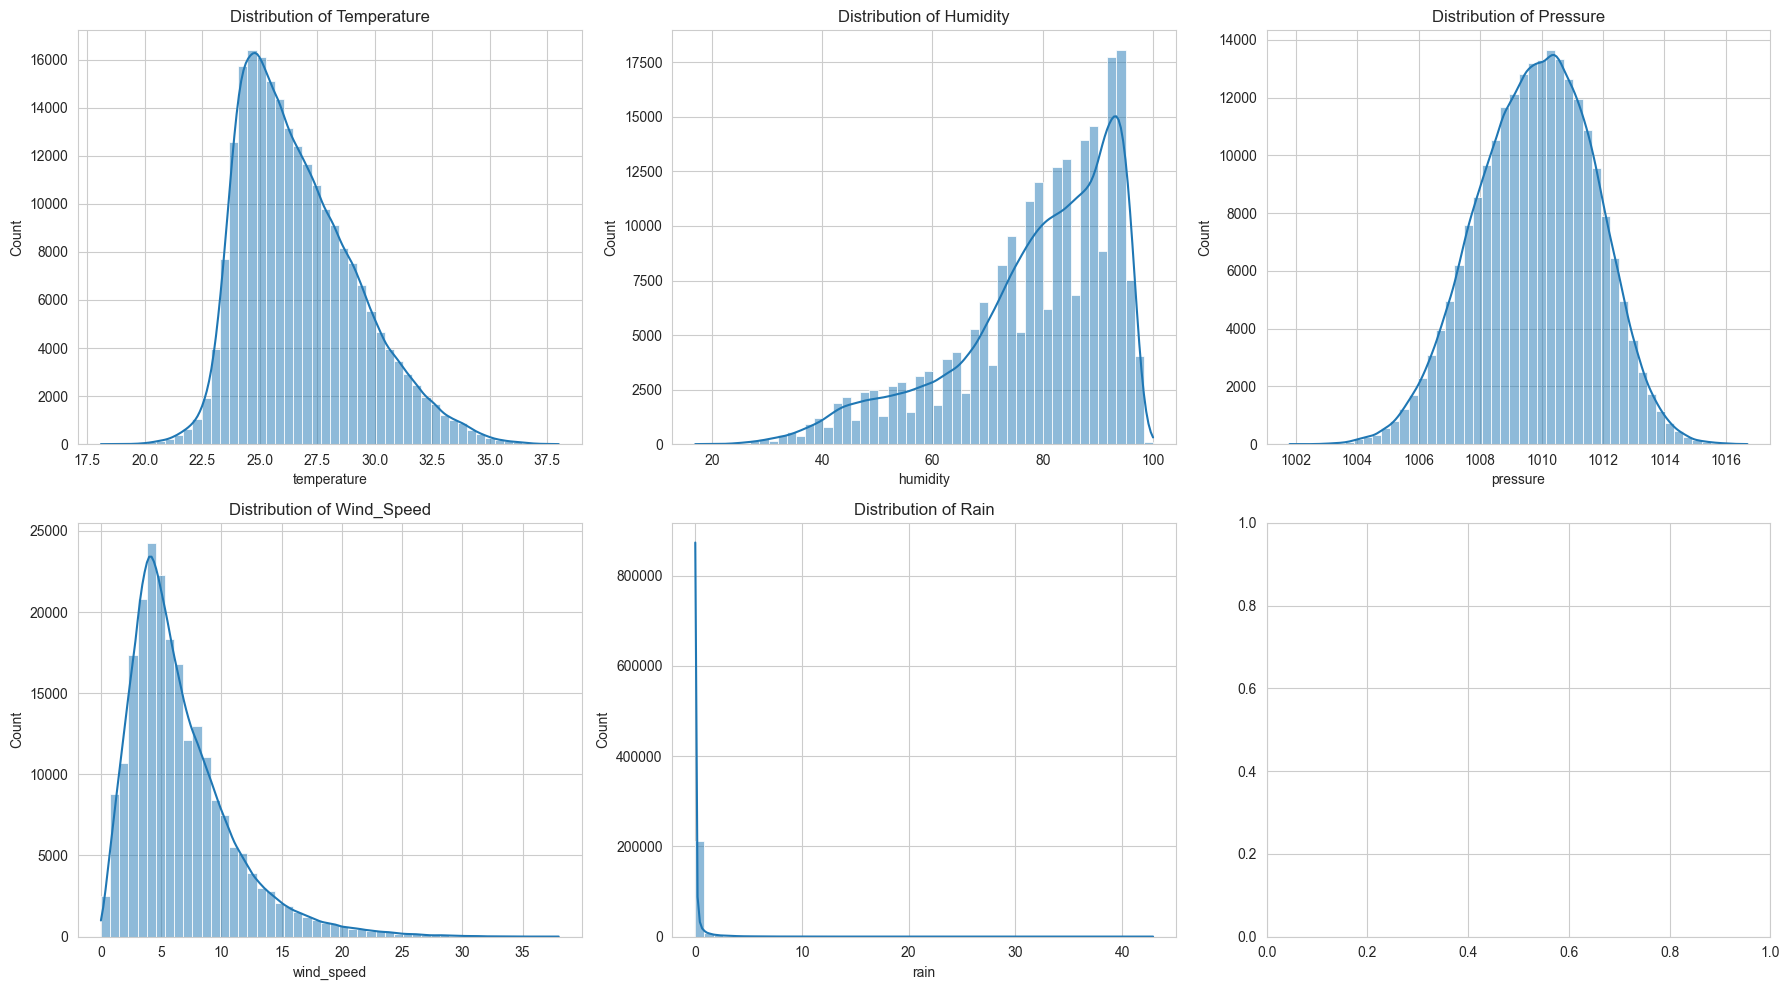

In [3]:
# 2.1 Distribution of Variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
columns = ['temperature', 'humidity', 'pressure', 'wind_speed', 'rain']

for i, col in enumerate(columns):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Distribution of {col.title()}')

plt.tight_layout()
plt.show()

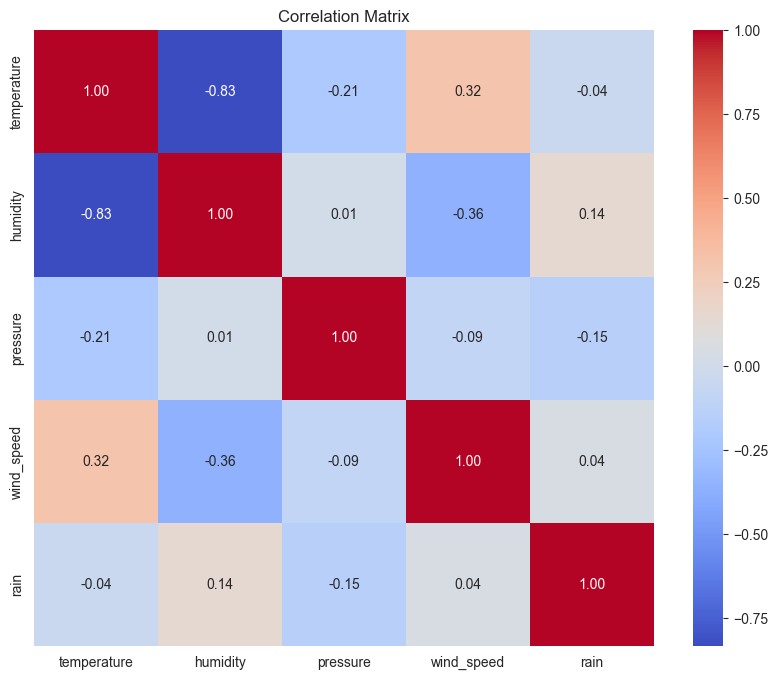

In [4]:
# 2.2 Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

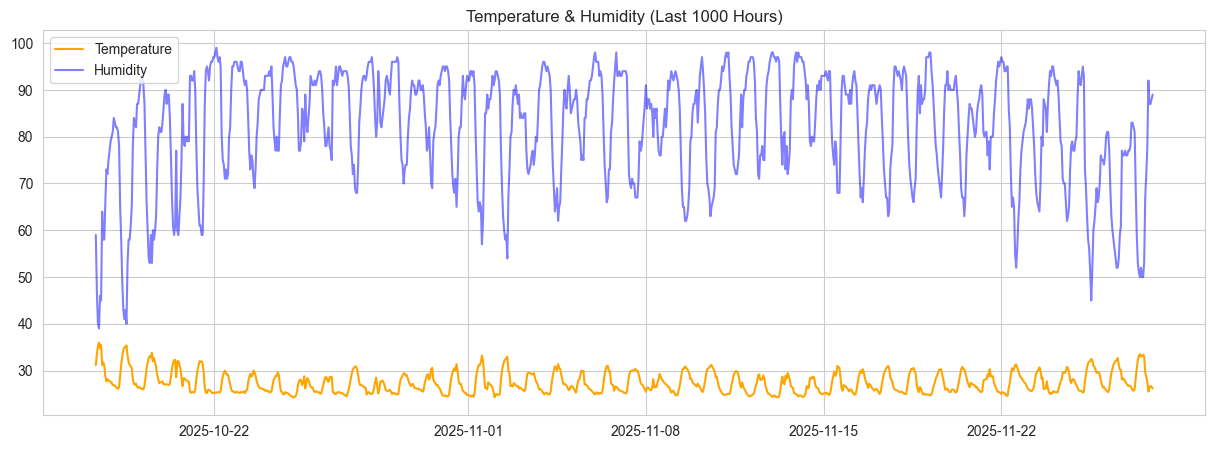

In [5]:
# 2.3 Time Series View (Last 1000 hours)
subset = df.tail(1000)
plt.figure(figsize=(15, 5))
plt.plot(subset['time'], subset['temperature'], label='Temperature', color='orange')
plt.plot(subset['time'], subset['humidity'], label='Humidity', color='blue', alpha=0.5)
plt.title('Temperature & Humidity (Last 1000 Hours)')
plt.legend()
plt.show()

## 3. Feature Engineering

In [6]:
# 3.1 Temporal Features
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['day_of_year'] = df['time'].dt.dayofyear

# 3.2 Cyclical Encoding (Hour & Month)
# This helps the model understand that hour 23 is close to hour 0
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 3.3 Lag Features (Previous hour values)
# Shift data by 1 hour to use past data for prediction
cols_to_lag = ['temperature', 'humidity', 'pressure', 'wind_speed', 'rain']
for col in cols_to_lag:
    df[f'{col}_lag_1'] = df[col].shift(1)

# 3.4 Rolling Statistics (Trends)
# 3-hour and 6-hour rolling means
for col in ['temperature', 'humidity']:
    df[f'{col}_roll_3h'] = df[col].rolling(window=3).mean()
    df[f'{col}_roll_6h'] = df[col].rolling(window=6).mean()

# 3.5 Target for Rain Classification
# 1 if rain > 0, else 0
df['is_raining'] = (df['rain'] > 0).astype(int)

# Drop NaN values created by shifting/rolling
df_clean = df.dropna()

print(f"Data after Feature Engineering: {df_clean.shape}")
df_clean.head()

Data after Feature Engineering: (227107, 23)


,time,temperature,humidity,pressure,rain,wind_speed,hour,month,day_of_year,hour_sin,...,temperature_lag_1,humidity_lag_1,pressure_lag_1,wind_speed_lag_1,rain_lag_1,temperature_roll_3h,temperature_roll_6h,humidity_roll_3h,humidity_roll_6h,is_raining
5,2000-01-01 05:00:00,23.1,94,1006.5,0.0,2.9,5,1,1,0.965926,...,23.3,94.0,1006.7,4.0,0.0,23.266667,23.466667,94.000000,94.333333,0
6,2000-01-01 06:00:00,23.2,95,1007.3,0.0,2.6,6,1,1,1.000000,...,23.1,94.0,1006.5,2.9,0.0,23.200000,23.366667,94.333333,94.333333,0
7,2000-01-01 07:00:00,25.2,89,1008.3,0.0,2.2,7,1,1,0.965926,...,23.2,95.0,1007.3,2.6,0.0,23.833333,23.650000,92.666667,93.333333,0
8,2000-01-01 08:00:00,26.1,85,1008.6,0.0,4.9,8,1,1,0.866025,...,25.2,89.0,1008.3,2.2,0.0,24.833333,24.050000,89.666667,91.833333,0
9,2000-01-01 09:00:00,27.0,82,1008.6,0.0,7.3,9,1,1,0.707107,...,26.1,85.0,1008.6,4.9,0.0,26.100000,24.650000,85.333333,89.833333,0


## 4. Train-Test Split

In [7]:
# Define Features (X)
feature_cols = [
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_year',
    'temperature_lag_1', 'humidity_lag_1', 'pressure_lag_1', 'wind_speed_lag_1', 'rain_lag_1',
    'temperature_roll_3h', 'temperature_roll_6h', 'humidity_roll_3h', 'humidity_roll_6h'
]

X = df_clean[feature_cols]

# Define Targets (y)
# Regression targets
y_reg = df_clean[['temperature', 'humidity', 'pressure', 'wind_speed']]
# Classification target
y_class = df_clean['is_raining']

# Split data
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_reg, y_class, test_size=0.2, random_state=42, shuffle=False # Shuffle=False for time series!
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 181685
Testing samples: 45422


## 5. Model Training

In [8]:
# 5.1 Regression Models (Temp, Humid, Press, Wind)
print("Training Regression Model...")
reg_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
reg_model.fit(X_train, y_reg_train)
print("✓ Regression Model Trained")

# 5.2 Classification Model (Rain)
print("Training Classification Model for Rain...")
class_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, class_weight='balanced')
class_model.fit(X_train, y_class_train)
print("✓ Classification Model Trained")

Training Regression Model...


✓ Regression Model Trained
Training Classification Model for Rain...


✓ Classification Model Trained


## 6. Evaluation

In [9]:
# 6.1 Regression Evaluation
y_reg_pred = reg_model.predict(X_test)
targets = ['temperature', 'humidity', 'pressure', 'wind_speed']

print("="*60)
print("REGRESSION METRICS")
print("="*60)

for i, target in enumerate(targets):
    mae = mean_absolute_error(y_reg_test.iloc[:, i], y_reg_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_reg_test.iloc[:, i], y_reg_pred[:, i]))
    r2 = r2_score(y_reg_test.iloc[:, i], y_reg_pred[:, i])
    
    print(f"{target.upper()}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2: {r2:.4f}\n")

REGRESSION METRICS
TEMPERATURE:
  MAE: 0.4661
  RMSE: 0.6266
  R2: 0.9459

HUMIDITY:
  MAE: 1.7974
  RMSE: 2.4380
  R2: 0.9736

PRESSURE:
  MAE: 0.4235
  RMSE: 0.5785
  R2: 0.8968

WIND_SPEED:
  MAE: 1.7973
  RMSE: 2.4076
  R2: 0.7764



RAIN CLASSIFICATION METRICS
Accuracy: 0.8588

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     32515
           1       0.82      0.65      0.72     12907

    accuracy                           0.86     45422
   macro avg       0.84      0.80      0.81     45422
weighted avg       0.86      0.86      0.85     45422



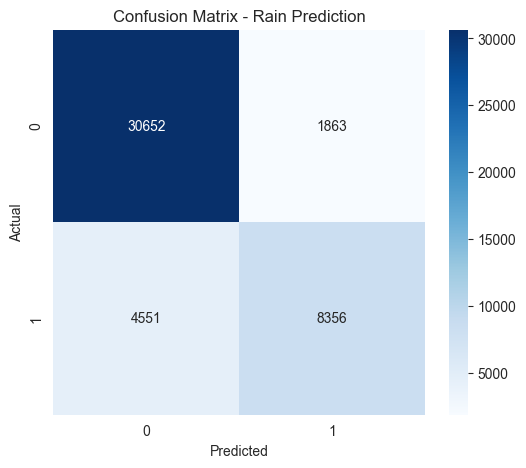

In [10]:
# 6.2 Classification Evaluation (Rain)
y_class_pred = class_model.predict(X_test)

print("="*60)
print("RAIN CLASSIFICATION METRICS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_class_test, y_class_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_class_test, y_class_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_class_test, y_class_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Rain Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 7. Feature Importance

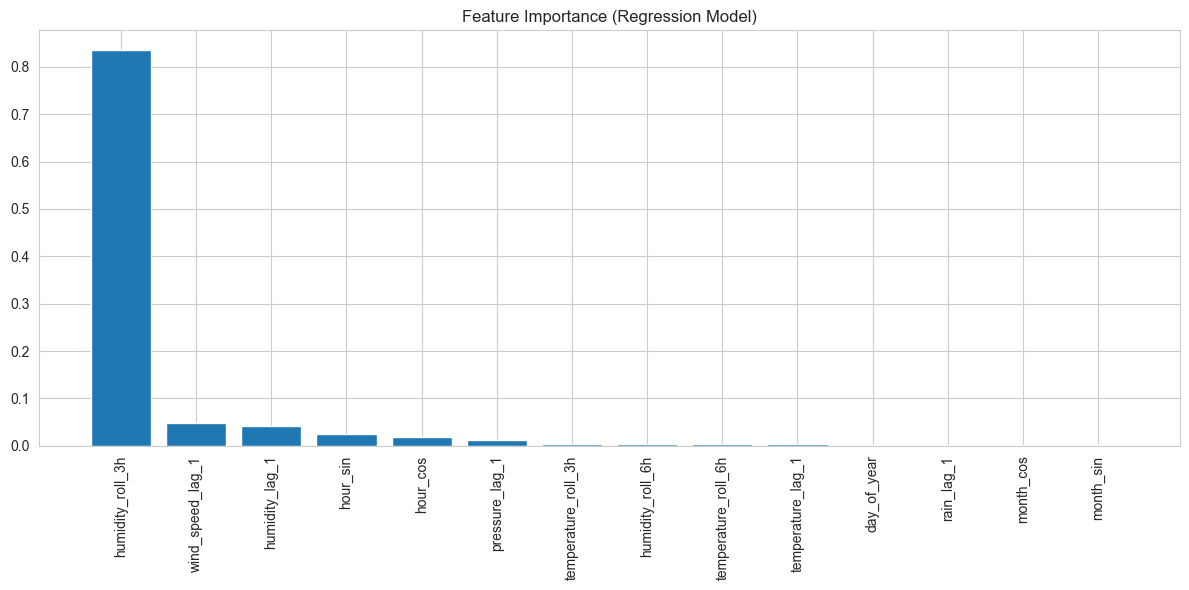

In [11]:
# Feature Importance for Regression (Temperature as example)
importances = reg_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Regression Model)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## 8. Save Models

In [12]:
import pickle
import os

# Create models directory if it doesn't exist
models_dir = 'D://laragon//www//weather-iot//examples//model_training//models//'
os.makedirs(models_dir, exist_ok=True)

# Save Regression Model
reg_model_path = os.path.join(models_dir, 'weather_regression_model.pkl')
with open(reg_model_path, 'wb') as f:
    pickle.dump(reg_model, f)
print(f"Regression model saved to: {reg_model_path}")

# Save Classification Model
class_model_path = os.path.join(models_dir, 'weather_rain_classifier.pkl')
with open(class_model_path, 'wb') as f:
    pickle.dump(class_model, f)
print(f"Classification model saved to: {class_model_path}")

Regression model saved to: D://laragon//www//weather-iot//examples//model_training//models//weather_regression_model.pkl


Classification model saved to: D://laragon//www//weather-iot//examples//model_training//models//weather_rain_classifier.pkl
